In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EL_Cyberbullying/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [7]:
#Remove duplicates per row
df.drop_duplicates(inplace=True)
df.describe()

,tweet_text,cyberbullying_type
count,47656,47656
unique,46017,6
top,@sschinke @Blackamazon @shanley also sorta wor...,religion
freq,2,7997


In [8]:
pd.set_option('display.max_colwidth', None)
df_groupby_tweet=df.groupby('tweet_text').count().sort_values(by='cyberbullying_type', ascending=False).reset_index()
df_groupby_tweet[df_groupby_tweet['cyberbullying_type']>1]

,tweet_text,cyberbullying_type
0,What a riveting little lesson in walking the catwalk. Thanks ladies #MKR,2
1,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",2
2,@NedGilmore oh! go get meat from south.,2
3,@kate_1985 - not sure!! But never fear @mykitchenrules still has 751 teams left and another Instant Restaurant round to come. #MKR,2
4,@NetTxt doesn't work that way. Sorry to disappoint you. No one cares what you want.,2
...,...,...
1634,RT @HelpIamaCabbage: @freebsdgirl People are spending money to try to get you temporarily suspended from twitter? That may be the most was…,2
1635,TODO: email tax guy to ask if lavender bath bombs qualify as a business expense.,2
1636,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",2
1637,"RT @DustyPee: If #cuntandandre make it through, I'll... I don't know what I will do. #mkr",2


In [9]:
df[df['tweet_text']=="Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR"]

,tweet_text,cyberbullying_type
9109,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",gender
28463,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",other_cyberbullying


In [10]:
df[df['tweet_text']=="@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself."]

,tweet_text,cyberbullying_type
6686,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",not_cyberbullying
29619,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",other_cyberbullying


In [11]:
#Remove duplicates based on tweet text. Keep only on cyberullying type per tweet
df.drop_duplicates(subset='tweet_text', keep="first", inplace=True)
df.describe()

,tweet_text,cyberbullying_type
count,46017,46017
unique,46017,6
top,"In other words #katandandre, your food was crapilicious! #mkr",religion
freq,1,7995


In [12]:
#Number of tweets per type of cyberbullying (after removing duplicates)
df.groupby('cyberbullying_type').count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7952
gender,7898
not_cyberbullying,7937
other_cyberbullying,6243
religion,7995


### Preprocess tweets


In [13]:
stemmer = SnowballStemmer("english")
stemmer.stem("studies")

'studi'

In [14]:
lematizer=WordNetLemmatizer()
lematizer.lemmatize("studies")

'study'

In [15]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lematizer=WordNetLemmatizer()

def preprocess_tweet(tweet, stem=True):
    #Remove special caracters, links and user tags
    regexp_pattern="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    tweet = re.sub(regexp_pattern, ' ', str(tweet).lower()).strip()
    #Remove stopwords
    tweet=" ".join([word for word in str(tweet).split() if word not in stop_words])
    #Stemming: Removes suffixes and prefixes. Ex. studies->studi.
    if stem==True:
        tweet= " ".join([stemmer.stem(word) for word in tweet.split()])
    #Lemmatizing: Gets the root word (better). studies->study
    tweet=" ".join([lematizer.lemmatize(word) for word in tweet.split()])
    return tweet

In [16]:
#Preprocess tweets
df['tweet_cleaned']=df['tweet_text'].apply(preprocess_tweet)
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretend kurdish account like islam lie


In [17]:
df.groupby('tweet_cleaned').count().sort_values(by='cyberbullying_type', ascending=False).reset_index()

,tweet_cleaned,tweet_text,cyberbullying_type
0,,271,271
1,fuck dumb nigger,45,45
2,bulli,43,43
3,yes,25,25
4,feminazi,24,24
...,...,...,...
44913,halalflaw biebervalu come moron let go vers quran start 33 33 afraid,1,1
44914,halalflaw biebervalu greenlinerzjm bitch copi hadith go look hadith bitch,1,1
44915,halalflaw biebervalu greenlinerzjm go look word taquiyya,1,1
44916,halalflaw biebervalu greenlinerzjm islam cultur islam religion,1,1


In [18]:
#Remove empty tweets
df.dropna(subset = ["tweet_cleaned"], inplace=True)

In [19]:
df[df['tweet_cleaned']=='feminazi']
#Should be remove duplicates after cleaning tweet?

,tweet_text,cyberbullying_type,tweet_cleaned
8222,@piojaa_ feminazi,gender,feminazi
8503,@Bourgholtzer feminazi,gender,feminazi
9765,FEMINAZI,gender,feminazi
9791,'Feminazi' http://t.co/Y5skW0daNu,gender,feminazi
10138,@Fernandarova feminazi,gender,feminazi
11378,@FunkAd3 feminazi.,gender,feminazi
12134,To feminazi,gender,feminazi
12181,Feminazi (?),gender,feminazi
12385,Feminazi.,gender,feminazi
12817,Feminazi 😳,gender,feminazi


### Feature engineering

In [20]:
#Assign ids to each cyberbullying type
types=df['cyberbullying_type'].unique()
types_ids=[0,1,2,3,4,5]
df_cyber_types=pd.DataFrame(list(zip(types, types_ids)),
               columns =['cyberbullying_type', 'cyberbullying_id'])
df_cyber_types

,cyberbullying_type,cyberbullying_id
0,not_cyberbullying,0
1,gender,1
2,religion,2
3,other_cyberbullying,3
4,age,4
5,ethnicity,5


In [21]:
#Add cyberbullying ids to the full data
df=pd.merge(df, df_cyber_types, how='left', on='cyberbullying_type')
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned,cyberbullying_id
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr,0
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc,0
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classi whore red velvet cupcak,0
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thank head concern anoth angri dude twitter,0
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretend kurdish account like islam lie,0


In [22]:
#Get the length of the tweet: number of words
df['nwords']=(df['tweet_cleaned'].str.split()).apply(len)
#get number of letters
df['nletters']=(df['tweet_cleaned']).apply(len)
#get number of vowels
df['nvowels']=df['tweet_cleaned'].str.count(r'[aeiou]')
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned,cyberbullying_id,nwords,nletters,nvowels
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr,0,5,34,10
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc,0,11,92,31
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classi whore red velvet cupcak,0,5,30,9
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thank head concern anoth angri dude twitter,0,9,49,14
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretend kurdish account like islam lie,0,8,50,18


In [23]:
#Describe features for each cyberbullying type
df_features=df[['cyberbullying_type', 'nwords','nletters', 'nvowels']].groupby('cyberbullying_type').median().sort_values(by='nwords')
df_features

,nwords,nletters,nvowels
cyberbullying_type,,,
other_cyberbullying,7.0,42.0,13.0
not_cyberbullying,8.0,44.0,13.0
gender,12.0,72.0,22.0
ethnicity,14.0,77.0,22.0
age,16.0,94.0,29.0
religion,19.0,118.0,38.0


Text(0, 0.5, 'Median values')

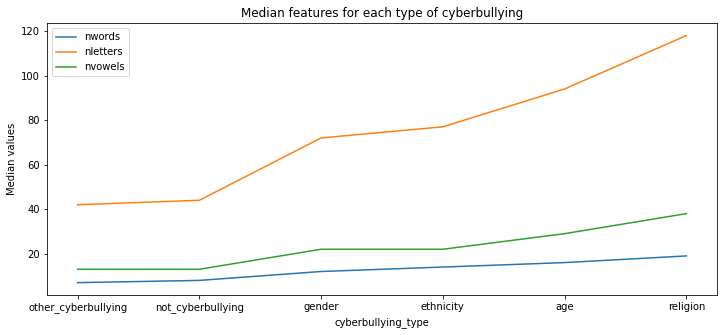

In [24]:
#Plot features
df_features.plot(figsize=(12, 5))
plt.title("Median features for each type of cyberbullying")
plt.ylabel("Median values")

In [25]:
#Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_names, y_test_names = train_test_split(np.array(df["tweet_cleaned"]),np.array(df["cyberbullying_id"]), np.array(df['cyberbullying_type']), test_size=0.25, random_state=0)
print(X_train.shape)
print(X_test.shape)

(34512,)
(11505,)


In [26]:
#TF_IDF Matrix
#initialise the vectorizer and then call fit and transform over it to calculate the TF-IDF score for the text
tf_idf = TfidfVectorizer(use_idf=True, min_df=0.00002, max_df=0.6)
#fit_transform(raw_documents), Parameters: raw_documents : iterable which yields either str, unicode or file objects
tf_idf_train_features = tf_idf.fit_transform(X_train.astype('U'))

tf_idf_test_features = tf_idf.transform(X_test.astype('U'))

print('TFIDF: Train features shape:', tf_idf_train_features.shape, ' Test features shape:', tf_idf_test_features.shape)

TFIDF: Train features shape: (34512, 32868)  Test features shape: (11505, 32868)


In [27]:
#the tuple represents sentence number and feature (word) number. The value in front is the tf-idf weight
#TF-IDF weights words based on relevance, one can use this technique to determine that the words with the highest relevance are the most important
print(tf_idf_train_features)

  (0, 4786)	0.18148708317878656
  (0, 25559)	0.19552250426430687
  (0, 13162)	0.22973943717885265
  (0, 21232)	0.258632132526771
  (0, 19455)	0.68136624772155
  (0, 14818)	0.5872841190264935
  (1, 29203)	0.3037284148782917
  (1, 14034)	0.5310665474779993
  (1, 3894)	0.3289965966953841
  (1, 11657)	0.18524148583663289
  (1, 2802)	0.3007617850512554
  (1, 31401)	0.32453218192542216
  (1, 16892)	0.3025211026414662
  (1, 22148)	0.1749913773233365
  (1, 17686)	0.40650266333664964
  (2, 31626)	0.3302444934413069
  (2, 17198)	0.16855960718373927
  (2, 27836)	0.33264460064404494
  (2, 10246)	0.42177067391322814
  (2, 24943)	0.18730718457967033
  (2, 23799)	0.3789413582625105
  (2, 2921)	0.2559836779095226
  (2, 10798)	0.5742605017880107
  (3, 21875)	0.260542338797588
  (3, 32223)	0.23042545311410112
  :	:
  (34510, 10855)	0.23776514206794963
  (34510, 28402)	0.20832963635406024
  (34510, 22550)	0.2200605911482168
  (34510, 14121)	0.20354802236782316
  (34510, 14657)	0.18040816043346078
  (3451

In [28]:
#Get the list of features names (in our case, features are words) and their index
feature_names={}
for i, feature in enumerate(tf_idf.get_feature_names_out()):
    feature_names[i]= feature
    if i>=23050 and i<=23070:
      print(i, feature_names[i])

23050 primeminist
23051 primer
23052 primero
23053 primila
23054 primit
23055 primordialradio
23056 primp
23057 princ
23058 princearihan
23059 princelaqroix
23060 princeofpersia
23061 princesmunchkin
23062 princess
23063 princessbravato
23064 princesskelsey7
23065 princeton
23066 princip
23067 principl
23068 print
23069 printer
23070 printout


### KNNbagging classifier and evaluation


In [29]:
# define and fit KNN bagging
KNNbagging = BaggingClassifier(KNeighborsClassifier(), n_estimators=50, max_samples=0.5, max_features=0.5, bootstrap = True)  #default estimators is 10
KNNbagging.fit(tf_idf_train_features,y_train_names)

BaggingClassifier(base_estimator=KNeighborsClassifier(), max_features=0.5,
                  max_samples=0.5, n_estimators=50)

In [30]:
# KNN Bagging performance...20 min to run
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(KNNbagging, tf_idf_train_features, y_train_names, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('KNN Bagging Classifier Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

KNN Bagging Classifier Accuracy: 0.698 (0.010)


In [32]:
# KNN Confusion matrix
lr = linear_model.LinearRegression()
KNNbag_predictions = KNNbagging.predict(tf_idf_test_features)
y_pred = cross_val_predict(lr, tf_idf_test_features, y_test, cv=3)
cmat=confusion_matrix(y_test_names, KNNbag_predictions) 
index = list(set(y_test_names))
columns = list(set(y_test_names))
KNN_cm_df = pd.DataFrame(cmat.astype(int),columns,index)
KNN_cm_df

,gender,not_cyberbullying,other_cyberbullying,religion,ethnicity,age
gender,1642,5,6,301,55,0
not_cyberbullying,2,1633,8,159,176,2
other_cyberbullying,4,5,1529,281,189,4
religion,26,9,28,1331,549,46
ethnicity,23,7,61,577,880,4
age,2,6,11,379,354,1211


<Figure size 432x288 with 0 Axes>

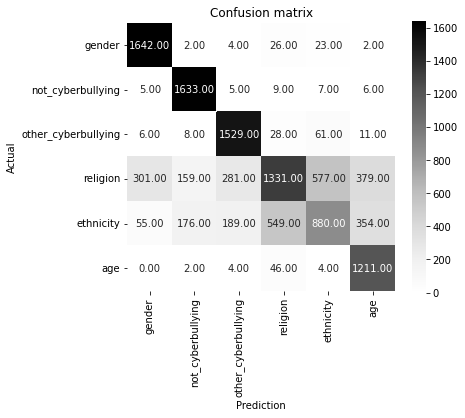

In [35]:
import seaborn as sn
plt.clf()
fig=plt.figure(figsize=(6, 5))

ax = fig.add_subplot(111)

ax.set_aspect(1)

res = sn.heatmap(KNN_cm_df.T, annot=True, fmt='.2f', cmap='Greys')

plt.title("Confusion matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [36]:
print(classification_report(y_test_names, KNNbag_predictions, target_names=list(set(y_test_names))))

                     precision    recall  f1-score   support

             gender       0.97      0.82      0.89      2009
  not_cyberbullying       0.98      0.82      0.90      1980
other_cyberbullying       0.93      0.76      0.84      2012
           religion       0.44      0.67      0.53      1989
          ethnicity       0.40      0.57      0.47      1552
                age       0.96      0.62      0.75      1963

           accuracy                           0.71     11505
          macro avg       0.78      0.71      0.73     11505
       weighted avg       0.79      0.71      0.74     11505

